# Chapter 4: Analysis and Comparison Samples

<div class="alert alert-block alert-info">

### This Notebook will lead you through exercises to help you compare your results to larger samples of exoplanets, and to place them in the context of the 'bigger picture'.

The tools described below are intended to provide you with ideas and ways in which to analyse your data. You therefore should not feel the need to use all statistical tests and tools described if they do not apply to the analysis that you had in mind.

### In this notebook, you will:

-  Take into account selection effects when analysing sample properties

-  Analyse and model any underlying trends in your data set, and learn to quantify how well a given model represents the data

-  Identify outliers in your sample distribution

-  Learn to quantify the significance of any apparent correlations between paramaters of interest

-  Learn to make statistical comparisons between the properties of your source and other exoplanet populations
    
### Table of contents:

- [1. Galaxy mass-to-light ratio: a case study](#sec:MLR)

    - [1.1 Selection effects](#ssec:sels)

    - [1.2 Linear fits](#ssec:fits)
  
    - [1.3 Residuals](#ssec:residuals)
    
    - [1.4 Confidence intervals and outliers](#ssec:conf)
        - [2D sample distributions](#ssec:2dsamp)
- [2. Ranks correlations](#sec:rank)
    - [2.1 Parametric and non-parameteric correlation tests](#ssec:ranktypes)
    - [2.2 The null hypothesis and p-value](#ssec:pvalue)
- [3. Sample populations and selection effects](#sec:seleffects)
- [Summary](#sec:summary)
    
</div>

## Parameter distributions and correlations
Once you have measured some physical properties for your target, an obvious question to ask will be how these properties compare to those of other exoplanets, and what new information (if any) is provided by your target. Any such analysis should:

$\bullet$ be carried out using statistical tools to be able to quantify the relation between your object and other samples of exoplanets

$\bullet$ consider the effects of error bars, and incorporate these uncertainties in any statistical comparison carried out

$\bullet$ investigate the effect of selection effects and understand the limitations of your data in addressing a given science question

<div class="alert alert-block alert-info">

Below are some examples of science data unrelated to exoplanets, but which works to illustrate some of the tools and statistical methods available that you may wish to use on your exoplanet samples. You will need to apply these methods to exoplanet data.
    
</div>

<a id="sec:MLR"></a>
# Galaxy mass-to-light ratio: a case study

<a id="ssec:sels"></a>
## 1.1 Selection effects
Many fields in astronomy ask the question of whether properties and physical parameters describing some given astronomical object evolve with redshift (where higher redshift objects are at larger distances and therefore probe earlier times in the Universe). One such example is whether the mass distribution of galaxies at higher redshifts (earlier times) differs from what we see in the local Universe. The mass distribution of galaxies can be compared to models to help us learn how galaxies evolved and gained their stellar mass. However, lower mass galaxies are harder to detect the more distant they are, and it is important to be aware of when this possible selection effect may be influencing our observations. This selection effect is very similar to selection effects seen in the exoplanet population. Have a look at your lecture notes from PH20104 or the "Exoplanet Recap" lecture on selection effects.

Below I have simulated a data set of galaxies with a range of stellar mass, M$_\star$, luminosity, L$_\star$, and redshift, $z$.

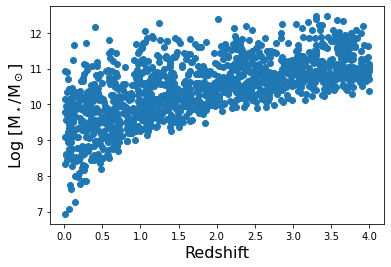

In [20]:
# Read in packages necessary for analysis
import numpy as np
from M2L import sample_sim
from astropy.cosmology import WMAP9 as cosmo
import pylab
import matplotlib.cm as cm
import pandas as pd

# Read in simulated data set
z,Mass,Merr,Lum = sample_sim()

# Plot the galaxy stellar mass against redshift in units of solar mass (M_\odot)
pylab.plot(z,Mass,'o')
pylab.xlabel('Redshift',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)
pylab.show()

##### Interesting...smaller galaxies with M$_\star <10^{10}$M$_\odot$ didn't exist at $z>1$

##### Is this true, or might selection effects be skewing our M$_\star$ distribution?  

To test whether select effects may have produced the above distribution, we can try and model our selection effects as follows:

$\bullet$ There is a known relation between galaxy stellar mass and galaxy luminosity (although with some scatter). This is known as the mass-to-light ratio.

$\bullet$ All instruments have a flux sensitivity limit for some given exposure time, and sources with flux below this sensitivity limit cannot be detected

$\bullet$ Although the flux sensitivity limit is a constant, the flux from a source of the same given luminosity decreases with distance squared. A constant flux limit thus translates to an evolving luminosity limit that increases with redshift (i.e. the luminosity threshold below which sources are no longer detectable increases with redshift)

The above data set was simulated assuming a flux sensitivity limit of $10^{-16}$ erg/cm$^2$/s. Given this flux sensitivity limit, we can then calculate the corresponding luminosity limit for the redshift distribution of the above sample. For different mass-to-light ratios, the calculated luminosity limit will translate to a different, redshift-dependent mass limit. In the code below I therefore plot what this stellar mass limit would be for a few different mass-to-light ratios (M/L) to see whether any of the resulting, modelled mass limits describe well the lower mass range distribution of our sample.

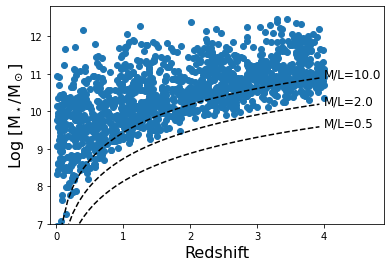

In [21]:
# Plot data, as above
pylab.plot(z,Mass,'o')

# Instrument flux sensitivy limit
flux_limit = 10.**-16 # erg/cm2/s

# Create an array of 4/0.08=50 dummy redshift values, going up from z=0.01 in intervals of 0.08, up to z=4
zrange = np.arange(0.01,4,0.08)

# Calculate the corresponding luminosity distance, Dl, in cm for each dummy redshift in our array
Mpc=3.086e24 # cm2
Dl = cosmo.luminosity_distance(zrange).value * Mpc

# Model the corresponding mass sensitivity limit at each redshift in the zrange array created above,
# given the above instument flux limit, and assuming three different mass-to-light ratios M/L = 2,5,10
for M2L in [0.5, 2, 10]:
    # Calculate luminosity sensitivy limit at luminosity distance Dl
    Llimit = 4. * np.pi * Dl**2 * flux_limit
    # Calculate corresponding stellar mass limit, converting to units of solar mass, Msol
    Msol = 1.998e33 # units of grams
    Mlimit = np.log10(Llimit * M2L/Msol) # In log10
    
    # Plot modelled mass sensitivity limit for some given M/L, M2L
    pylab.plot(zrange,Mlimit,c='k',ls='--')
    pylab.text(4,(Mlimit[-1]),"M/L=%.1f"%M2L,fontsize=12) # Plot label on plot

# Set plot parameters, and axis titles
pylab.xlim(-0.1,4.9)
pylab.ylim(7,12.8)
pylab.xlabel('Redshift',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)
pylab.show()

The stellar mass limits expected from an average galaxy mass-to-light ratio of M/L=2 seems to explain the observed, lower mass range of galaxies at increasing redshift very well

<a id="ssec:fits"></a>
## 1.2 Linear fits
Let's now assume that I also have the luminosities for my galaxy sample, and I now want to verify whether mass and luminosity are correlated, and what the relation between the two parameters is.

Text(0, 0.5, 'Log [M$_\\star$/M$_\\odot$]')

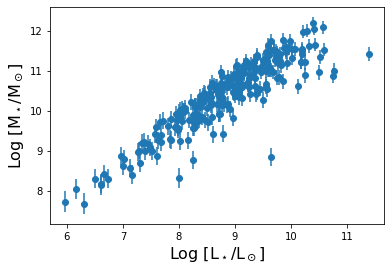

In [22]:
# Simulate a new stellar mass and lumiosity data set containing 100 data points
z,Mass,Merr,Lum = sample_sim(n=100)

# Plot stellar mass against luminosity
pylab.errorbar(Lum,Mass,yerr=Merr,fmt='o')
pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)

The data appear to have a linear relation. Let's find the line of best-fit using curve_fit (see Chapter3_ModellingToolbox notebook)

In [23]:
# Some necessary modules to read in sample parameters from a file... 
from scipy.optimize import curve_fit

# Function definition to apply linear fit to input (x-array) data (with intercept=0)
def linfit(xdata, a):
    return xdata*a

# Let's try a linear fit to the data (my linfit function definition has been imported from CompSample.py)
popt,pcov = curve_fit(linfit,Lum,Mass,p0=[10])

a = popt[0]
aerr = np.sqrt(pcov[0][0])

print('\033[1m' + "Linear fit has best-fit parameter:\n\tM/L = %.3f +/- %.3f\n" % (a,aerr) + '\033[0m')

Linear fit has best-fit parameter:
	M/L = 1.172 +/- 0.003



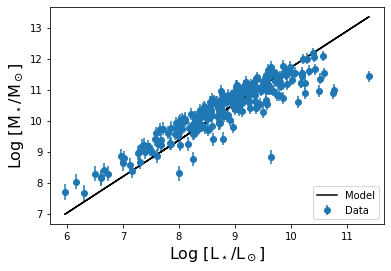

In [24]:
# Let's see how the fit looks

# Plot data points...
pylab.errorbar(Lum,Mass,yerr=Merr,fmt='o',label='Data')
pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)

# ..along with best-fit linear fit
pylab.plot(Lum, linfit(Lum,a),c='k',zorder=2,label='Model')
pylab.legend(loc=4)

<a id="ssec:residuals"></a>
## 1.3 Residuals
A very useful way of checking the validy of a model is to look at the residuals, which corresponds to the ratio of the data over the model. A perfect model would give residuals of 1.

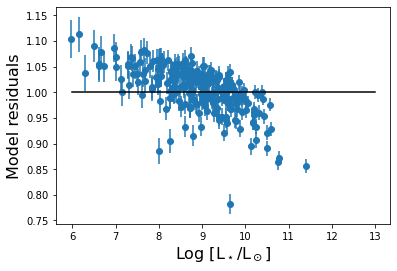

In [25]:
# Let's check the residuals on the modelled mass-luminosity relation
pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
pylab.ylabel('Model residuals',fontsize=16)
pylab.errorbar(Lum, Mass/linfit(Lum,a), Merr/linfit(Lum,a),fmt='o',zorder=1)
pylab.plot([6,13], [1.0,1.0],c='k',zorder=2)

The model underestimates M$_\star$ at low L$_\star$, but overestimate M$_\star$ at high L$_\star$

<a id="ssec:conf"></a>
## 1.4 Confidence intervals and outliers

So far we have only considered the quality of our fits by eye-balling the above plots. Let's now try and quantify how well our model fits the data by considering our uncertainties and the outliers in our sample.

For the purpose of illustrating the uncertainty on model fits and the presence of outliers, below we consider a subset of the above mass-luminosity sample, and consider the 3-sigma uncertainty on our model.

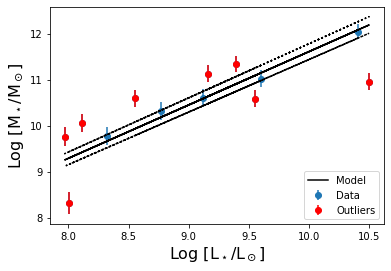

In [26]:
# Let's first consider a smaller sample
# I now select only every 20th data point in my stellar mass, luminosity sample
Lumsub = Lum[1::20]
Masssub = Mass[1::20]
Merrsub = Merr[1::20]

# We again fit the data using a linear fit
# NOTE: this time I am taking into account the uncertainties on stellar mass in my fit
# This is done by setting the sigma argument to your array of x-axis uncertainties
# and absolute_sigma=True
popt,pcov = curve_fit(linfit,Lumsub,Masssub,sigma=Merrsub,absolute_sigma=True)
a = popt[0]
aerr = np.sqrt(pcov[0][0])

# Correspondingly, this time I plot the model now including the model uncertainties
# Firt plot the data
pylab.errorbar(Lumsub, Masssub,yerr=Merrsub,fmt='o',zorder=1,label='Data')
pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)
# And then plot the best-fit model
pylab.plot(Lumsub, linfit(Lumsub,a),c='k',zorder=2,label='Model')
# Also plot the 3sigma upper and lower bound on the best-fit model
pylab.plot(Lumsub, linfit(Lumsub,a+(3*aerr)),c='k',ls='dotted',zorder=2)
pylab.plot(Lumsub, linfit(Lumsub,a-(3*aerr)),c='k',ls='dotted',zorder=2)

# Find what the ratio is between the upper bound of your data point (i.e. considering 1 sigma uncertainties)
# and the 3-sigma lower bound set by your model
lo_outliers = ((Masssub+Merrsub)/linfit(Lumsub,a-(3*aerr)))
# Similarly, for the lower bound of the data points and upper bound of the model
hi_outliers = ((Masssub-Merrsub)/linfit(Lumsub,a+(3*aerr)))

# Identify those data points that lie outside the 3 sigma uncertainty region
sel = (lo_outliers<1) | (hi_outliers>1)
# And plot these outliers in red
pylab.errorbar(Lumsub[sel], Masssub[sel],yerr=Merrsub[sel],fmt='or',zorder=3,label='Outliers')
pylab.legend(loc=4)

Note that the above figure highlights in red those galaxies that lie outside the best-fit model 99.7% confidence region, including the 1sigma uncertainties. However, many of the red data points are $<3\sigma$ away from this 99.7% confidence region.

<a id="ssec:2dsamp"></a>
### 2D sample distributions
Those outliers shown above in red which are inconsistent (at 1sigma) with our best-fit mass-metallicity linear model imply that a single mass-to-light ratio does not provide a good description of the properties present in our data set. Presumably there is a range of mass-to-light ratios. 

Rather than considering outliers relative to some model, let's now consider outliers relative to the general distribution of data points. This is a model-independenrt way of looking for galaxies that show particularly large or low mass-to-light ratios when compared to the rest of the sample.

Text(0, 0.5, 'Log [M$_\\star$/M$_\\odot$]')

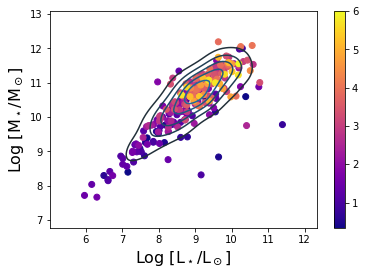

In [39]:
# Import package necessary to determine distribution of data points
# and to be able to colour-code by number density
from CompSample import density_scatter
import seaborn as sns
import matplotlib.cm as cm

# Let's set the colours of each M-L data point according to the number density
# NOTE: the bins argument sets the number of bins in the M-L parameter space used
# to determine the density. If we only have 20 data points, bins=10 would be too large,
# since it would only give us 2 data points. Similarly, if we have 1000 data points,
# nbins=10 may be too small.
# The bins argument can have different dx and dy lengths 
dencol=density_scatter(Lum, Mass, bins = [30,30])

# Plot the data points, colour coded according to number density
pylab.scatter(Lum, Mass, c=dencol,cmap=cm.plasma) # c=dencal argument sets colour-coding according to number density
plt.colorbar()
# Now we can read in the data and plot the contour plots using the sns.kdeplot() function
# We can also draw contours using the n_levels argument.
sns.kdeplot(Lum, Mass, levels=5)

# Set the axis titles
pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)

The contour regions can be used to define our outliers. For example, any data points that lie outside the contour containing 95% (second plotted contour) of the population are inconsistent with the rest of the sample at 2 sigma.

<a id="sec:rank"></a>

# 2. Rank correlations: testing significance of a correlation

We have now explored how we might try and quantify the relation between two variables; in the case above we found that galaxy stellar mass and luminosity are positively correlated. However, it is also important to be able to quantify how significant this relation is.

To test this, we can use rank correlations to test the signifance of the relation between two parameters. A rank correlation coefficient measures the degree of similarity between two rankings, and can be used to assess the significance of the relation between them.

All rank correlation tests return a corresponding *rank correlation coefficient* which will lie within the interval [-1,1] and have the following meaning:

1: the agreement between the two rankings is perfect

0: the rankings are completely independent

-1: the disagreement between the two rankings is perfect, so they are inversely related. 

<a id="ssec:ranktypes"></a>

## 2.1 Parametric versus non-parametric correlation tests
There are several rank correlation tests, which use different algorithms to rank the parameters being compared.

The **Pearson's *r* rank correlation** is an example of a *parametric* test, which means that the variables being compared are normally distributed. Pearson's *r* correlation coefficient measures the linear correlation between two variables X and Y.

The **Spearman's $\rho$** and **Kendall's $\tau$** rank correlation tests, on the other hand, are examples of *non-parametric* tests, which means that the variables being compared are not normally distributed. The Spearman's $\rho$ rank coefficient assesses how well the relationship between two variables are described by a monotonic function. The Kendall's $\tau$ correlation test is generally better at assessing the relation between parameters in small samples and with potentially more complicated associations.

To decide which rank correlation test is appropriate for a given sample of parameters, a first step is therefore to plot a histogram of the parameters being tested to check whether they have a normal distribution.

<div class="alert alert-block alert-info">
    
Let's check the distribution of our mass and luminosity data

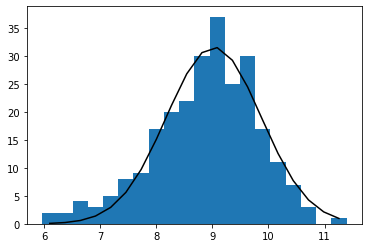

In [28]:
# Import necessary python packages
import matplotlib.pyplot as plt

# We can use the plt.hist() function to produce a histogram of our luminosity data
num, Lbins, patches = plt.hist(Lum,bins=20)
# NOTE: The values stored in the 'Lbins' array contains the min and max luminosity of each
# luminosity bin. Instead, the 'num' array contains the number of galaxies within each
# luminosity bin such that the Lbins array contains one element more than the num array. 

# Let's try and fit a Gaussian to the luminosity distribution
# First we need to define a Gaussian function
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Then, as above with our linear fits, we can fit out data with a Gaussian
# To guide the fit, we provide initial estimates for the Guassian mu and sigma values
mu_0=np.mean(Lbins)
sigma_0=np.std(Lbins)

# NOTE: Before we can fit a Gaussian to our histogram, we have to modify the Lbins array to
# have the same number of elements as the num array (see NOTE above). To do this we therefore
# produce an array containing the central value of each luminosity bin in the histogram.
binsize = (np.max(Lum)-np.min(Lum))/20.
Lbins_centre = Lbins[:-1]+binsize/2.
popt,pcov = curve_fit(gauss,Lbins_centre,num,p0=[1,mu_0,sigma_0])

# Let's read in the best-fit amplitude, mu and sigma values and then plot our distribution and the Guassian fit
amplitude = popt[0]
mu = popt[1]
sigma = popt[2]
y = gauss(Lbins_centre,amplitude,mu,sigma)
plt.plot(Lbins_centre, y, color ='black')

The fit seems reasonable, suggesting we can use the Pearson's *r* rank parameteric correlation test

<div class="alert alert-block alert-success">

### Your turn
Check that the the mass sample resembles a normal distribution.
    
</div>

For the purposes of this example, let's now consider a less well correlated data set than the mass-luminosity relation illustrated above.

Let's see how significant our luminosity-mass relation is if we only have a subset of our sample, and we randomize our data to make any correlation less obvious.

Text(0, 0.5, 'Log [M$_\\star$/M$_\\odot$]')

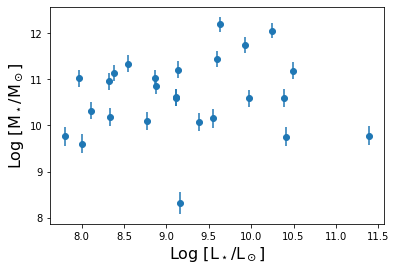

In [29]:
# Import package to randomize array
import random

# Select subsample..
randomLum = Lum[1::10]
randomMass = Mass[1::10]
randomMerr = Merr[1::10]
# ..and randomize the Luminosity values
random.shuffle(randomLum)

# Plot the data distribution
pylab.errorbar(randomLum, randomMass,yerr=randomMerr,fmt='o')
pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)

In [30]:
# Let's use the Spearman's rank test to assess the significance of our correlation

# First we import the necessary module
from scipy.stats import spearmanr

# Now let's calculate the spearman rank correficient
rank,sp_pvalue = spearmanr(randomLum,randomMass)

print('\033[1m' + "Luminosity and stellar mass have a Spearman's rank %.2f and p-value of %.2e" % (rank,sp_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is %.2f given the null hypothesis)' % (sp_pvalue*100,rank))

Luminosity and stellar mass have a Spearman's rank 0.15 and p-value of 4.60e-01

(I.e. there is 46.0% probability that the Speaman rank is 0.15 given the null hypothesis)


In [31]:
# Now let's see how the Pearon's correlation test compares
from scipy.stats import pearsonr
PCC,PCC_pvalue = pearsonr(randomLum,randomMass)

print('\033[1m' + "Luminosity and stellar mass have a Pearson's correlation coefficient %.2f and p-value of %.2e" % (PCC,PCC_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is %.2f given the null hypothesis)' % (PCC_pvalue*100,PCC))

Luminosity and stellar mass have a Pearson's correlation coefficient 0.12 and p-value of 5.62e-01

(I.e. there is 56.2% probability that the Speaman rank is 0.12 given the null hypothesis)


##### Both correlation tests above give similar results, indicating that a non-parametric test can be used on data that are normally distributed, but not vice-versa.

##### Both result is correlation coefficients that are fairly close to 0 - but what is the meaning of the p-value?

<a id="ssec:pvalue"></a>

## 2.2 The null hypothesis and p-value
In addition to providing a rank coefficient, the correlation tests also have an associated 'p-value', which provides the probability of finding a similar rank value given the null hypothesis that the two sets of parameters are uncorrelated. Therefore, low values of the p-value imply that the correlation rank is significant.

In statistics, ***the null hypothesis is the hypothesis that there is nothing new or special between two samples***. For example, that there is no association among groups, or no relationship between two measured phenomena. In the case of correlation tests, the null hypothesis is thus the premis that the two samples are not correlated. The p-value provides the probability of getting the measured correlation coefficent, given the null hypothesis.

In our test above, we measured some rank value with an associated p-value. The rank value alone tells us something about how correlated stellar mass and luminosity are, but the p-value then tells us how reliable this rank coefficient is. Small p-values tell us that there is a small probability of measuring the rank value that we measured if stellar mass and luminosity are *not* correlated. Conversely, large p-values tell us that there is a high probability of getting the rank value that we measured, even if the two comparison samples are not correlated. So if we measure a rank=0.8, which would be indicative of a strong positive correlation, but the p-value was 0.6, that would indicate that there is a high probability (60% chance) of measuring rank=0.8 even if the two parameters are not correlated. We therefore *would not* consider the measured high positive correlation as significant.

### How the p-value is calculated
Let's consider two data sets corresponding to completely independent and thus uncorrelated parameters. If we took multiple draws from these data sets and performed a rank correlation test for each draw, we would measure a distribution of rank values, some small fraction of which may indicate that the data are correlated. The distribution of these rank values enable us to determine what the probability is of obtainining any given rank value when the data are not correlated (i.e. the null hypothesis). For example, let's assume we re-ran the rank correlation test and obtain a rank value $\rho_1$. If our previously derived distribution of rank coefficients show that 3% of the time we can expect to have a value $\rho=\rho_1$, our measured rank value of $\rho_1$ then has an associated p-value of 0.03.

The distribution of rank values given the null hypothesis will depend on the number of data points used in the correlation tests. The larger the number of data points, the lower the probability of producing a correlation by chance, or conversely, of removing any signs of a correlation, when in fact there is one. It is fairly common to use 5% as the threshold probability below which we 'reject' the null hypothesis. I.e. if we measure some rank value with a p-value<0.05, it is then standard to reject the null hypothesis that the two parameters compared are *not* correlated.

This of course still means that there is up to 5% chance that you'll get the correlation coefficient that you measured, even when the parameters are not correlated. For example, see 'Spurious Correlations' (www.tylervigen.com/spurious-correlations ).

<div class="alert alert-block alert-success">

### Your turn
Try measuring the correlation coefficients and corresponding p-values for the full sample of stellar masses and luminosities simulated above (i.e. the Mass and Lum arrays)
    
</div>

<a id="sec:seleffects"></a>


# 3. Sample populations and selection effects
It is important to investigate the apparent difference in the regions of the mass-luminosity relation occupied by galaxies selected in different ways using statistical methods. In this context, an important question to ask is whether two galaxy samples are consistent or not with arising from the same parent population. For example, are the properties of exoplanets found through transits consistent with some other sample of exoplanets that are found using a different method? If not, then you need to consider whether this is because they really do represent two different subsamples of explanets, or is it merely an effect of selection effects.

## The Kolmogorov-Smirnov test
One way of tackling this question is using the Kolmogorov–Smirnov (KS) test, which is a non-parametric test that measures the similarity between the cumulative probability distribution of a data sample and a reference probability distribution (one-sample KS test), or between two data samples (two-sample KS test). In our case, we want to apply the two-sample KS test to make a quantative statement on whether our smaller and randomised mass-luminosity sample, and the larger simulated sample is consistent with being selected from the same parent population.

The KS statistic quantifies a distance between the cumulative distribution function of the two samples being compared. This is illustrated in the figure below, where the KS statistic, $D$, corresponds to the maximum vertical distance between the two cumulative probability distribution functions indicated by the black arrow in the figure below.

<img src="misc/KS2_Example.png" style="width: 300px;"/>

**Fig. 1.** *Illustration of the two-sample Kolmogorov–Smirnov statistic. Red and blue lines each correspond to an empirical distribution function, and the black arrow is the two-sample KS statistic, $D$. (credit: Wikipedia)*

The larger the value of $D$, the less likely that the two samples stem from the same parent population, and the significance of this is again quantified via the p-value. This is the probability of getting the difference $D$ given the null hypothesis that the two samples do not stem from the same parent population. Thus a small p-value indicates that the measured value of $D$ is very unlikely to arise given the null hypothesis, and we thus would believe that $D$ is representative of the difference between the two samples. I.e. a larger, measured $D$ and small p-value would indicate that the two samples are *inconsistent* with arising from the same parent population.

### Is my randomised sample of galaxy L-M pairs consistent with arising from the same parent population of a larger sample of galaxies?
Let's test this out by applying the KS test to the observed mass and luminosity distributions of our randomised sample, compared to the larger sample of simulated galaxies.

In [32]:
# Load in module needed to apply 2-D KS test
from scipy.stats import ks_2samp

# Apply KS test to the randomised luminosity distribution and a larger sample of galaxies
D, P = ks_2samp(randomLum,Lum)
print('\033[1m' + "The probability that D=%.2f given the null hypothesis is %.1f %% (i.e. the null hypothesis cannot be rejected)" % (D,P*100) + '\033[0m')

The probability that D=0.16 given the null hypothesis is 50.6 % (i.e. the null hypothesis cannot be rejected)


In [33]:
# Now lets compare the stellar mass distributions
D, P = ks_2samp(randomMass,Mass)
print('\033[1m' + "\nThe probability that D=%.2f given the null hypothesis is %.1f %% (i.e. the null hypothesis cannot be rejected)" % (D, P*100) + '\033[0m')


The probability that D=0.13 given the null hypothesis is 78.8 % (i.e. the null hypothesis cannot be rejected)


Given that my subsample was taken from the larger sample of simulated mass-luminosity values, the KS test correctly finds that we cannot reject the hypothesis that the two samples are inconsistent with each other and originate from different, underlying, parent populations of galaxies.

## Exoplanet properties and parameter dependencies

<div class="alert alert-block alert-success">

### Your turn - apply the above tools to exoplanet data

Given the parameters that you have measured for your exoplanet, what can you say about how it relates to the general population of exoplanets?

Maybe quantify the significance of any correlation between two exoplanet properties in a large sample of exoplanets, and use this to assess how consistent your exoplanet is with the larger population. Is your exoplanet an outlier in some parameter space, and is there any evidence of selection effects in the comparison sample of exoplanets?
    
</div>

In [34]:
nasa = pd.read_csv('NASAdata.csv', delimiter =',')
nasa.head()

,discoverymethod,semimajoraxis,radius,mass,density,eccentricity,inclination,ttv,depth
0,Imaging,NaN,6.725,NaN,NaN,NaN,NaN,0.0,NaN
1,Imaging,NaN,10.088,NaN,NaN,NaN,NaN,0.0,NaN
2,Imaging,NaN,10.088,NaN,NaN,NaN,NaN,0.0,NaN
3,Imaging,8.0,10.468,6992.0,NaN,NaN,NaN,0.0,NaN
4,Imaging,NaN,11.209,NaN,NaN,NaN,NaN,0.0,NaN


Text(0, 0.5, 'Depth [%]')

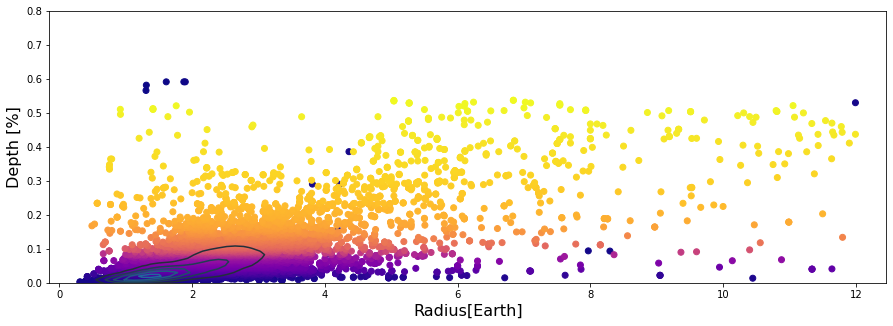

In [35]:
# Import package necessary to determine distribution of data points
# and to be able to colour-code by number density
from CompSample import density_scatter
import seaborn as sns
import matplotlib.cm as cm

# Let's set the colours of each M-L data point according to the number density
# NOTE: the bins argument sets the number of bins in the M-L parameter space used
# to determine the density. If we only have 20 data points, bins=10 would be too large,
# since it would only give us 2 data points. Similarly, if we have 1000 data points,
# nbins=10 may be too small.
# The bins argument can have different dx and dy lengths 

#transit_depth=nasa['depth'][np.isfinite(nasa['depth'])]
#radius=nasa['radius'][np.isfinite(nasa['radius'])]
#radius=radius[~np.isfinite(nasa['depth'])]
plt.figure(figsize=(15,5))
nasa1= nasa.dropna(axis=0,how='any',subset=['radius','depth'])
radius = np.array(nasa1['radius'])
depth= np.array(nasa1['depth'])
mask= (radius<12) & (depth<1)
dencol=density_scatter(radius[mask],depth[mask], bins = [100,100])

# Plot the data points, colour coded according to number density
pylab.scatter(radius[mask], depth[mask], c=dencol,cmap=cm.plasma) # c=dencal argument sets colour-coding according to number density

# Now we can read in the data and plot the contour plots using the sns.kdeplot() function
# We can also draw contours using the n_levels argument.
sns.kdeplot(radius[mask], depth[mask], levels=5)
plt.ylim(0,0.8)
# Set the axis titles
#pylab.xlabel(r'Log [L$_\star$/L$_\odot$]',fontsize=16)
#pylab.ylabel(r'Log [M$_\star$/M$_\odot$]',fontsize=16)
pylab.xlabel(r'Radius[Earth]',fontsize=16)
pylab.ylabel(r'Depth [%]',fontsize=16)


0.05889962928776327 -0.058229906332832294


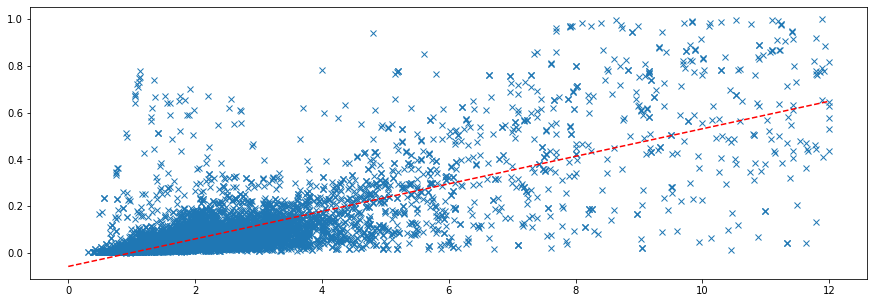

In [36]:
plt.figure(figsize=(15,5))
nasa1= nasa.dropna(axis=0,how='any',subset=['radius','depth'])
radius = nasa1['radius'][mask]
depth= nasa1['depth'][mask]
plt.plot(radius,depth,ls='None', marker='x')

def linearfit(x,m,c):
    return x*m +c

popt,pcov = curve_fit(linearfit,radius,depth)
xrange=np.linspace(0,12,100)
plt.plot(xrange,linearfit(xrange,*popt),ls='--',color='r')
print(*popt)

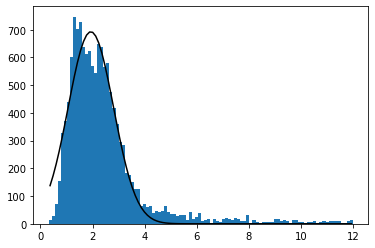

In [37]:
# We can use the plt.hist() function to produce a histogram of our luminosity data
num, Lbins, patches = plt.hist(radius,bins=100)
# NOTE: The values stored in the 'Lbins' array contains the min and max luminosity of each
# luminosity bin. Instead, the 'num' array contains the number of galaxies within each
# luminosity bin such that the Lbins array contains one element more than the num array. 

# Let's try and fit a Gaussian to the luminosity distribution
# First we need to define a Gaussian function
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Then, as above with our linear fits, we can fit out data with a Gaussian
# To guide the fit, we provide initial estimates for the Guassian mu and sigma values
mu_0=np.mean(Lbins)
sigma_0=np.std(Lbins)

# NOTE: Before we can fit a Gaussian to our histogram, we have to modify the Lbins array to
# have the same number of elements as the num array (see NOTE above). To do this we therefore
# produce an array containing the central value of each luminosity bin in the histogram.
binsize = (np.max(radius)-np.min(radius))/100.
Lbins_centre = Lbins[:-1]+binsize/2.
popt,pcov = curve_fit(gauss,Lbins_centre,num,p0=[1,mu_0,sigma_0])

# Let's read in the best-fit amplitude, mu and sigma values and then plot our distribution and the Guassian fit
amplitude = popt[0]
mu = popt[1]
sigma = popt[2]
y = gauss(Lbins_centre,amplitude,mu,sigma)
plt.plot(Lbins_centre, y, color ='black')

In [38]:
# We can use the plt.hist() function to produce a histogram of our luminosity data
num, Lbins, patches = plt.hist(mass,bins=50)
# NOTE: The values stored in the 'Lbins' array contains the min and max luminosity of each
# luminosity bin. Instead, the 'num' array contains the number of galaxies within each
# luminosity bin such that the Lbins array contains one element more than the num array. 

# Let's try and fit a Gaussian to the luminosity distribution
# First we need to define a Gaussian function
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Then, as above with our linear fits, we can fit out data with a Gaussian
# To guide the fit, we provide initial estimates for the Guassian mu and sigma values
mu_0=np.mean(Lbins)
sigma_0=np.std(Lbins)

# NOTE: Before we can fit a Gaussian to our histogram, we have to modify the Lbins array to
# have the same number of elements as the num array (see NOTE above). To do this we therefore
# produce an array containing the central value of each luminosity bin in the histogram.
binsize = (np.max(mass)-np.min(mass))/50.
Lbins_centre = Lbins[:-1]+binsize/2.
popt,pcov = curve_fit(gauss,Lbins_centre,num,p0=[1,mu_0,sigma_0])

# Let's read in the best-fit amplitude, mu and sigma values and then plot our distribution and the Guassian fit
amplitude = popt[0]
mu = popt[1]
sigma = popt[2]
y = gauss(Lbins_centre,amplitude,mu,sigma)
plt.plot(Lbins_centre, y, color ='black')

NameError: name 'mass' is not defined

In [ ]:
# Let's use the Spearman's rank test to assess the significance of our correlation

# First we import the necessary module
from scipy.stats import spearmanr

# Now let's calculate the spearman rank correficient
rank,sp_pvalue = spearmanr(radius,depth)

print('\033[1m' + "radius and depth have a Spearman's rank %.2f and p-value of %.2e" % (rank,sp_pvalue) + '\033[0m')

print('\n(I.e. there is %.2f%% probability that the Speaman rank is %.2f given the null hypothesis)' % (sp_pvalue*100,rank))

In [ ]:
# Now let's see how the Pearon's correlation test compares
from scipy.stats import pearsonr
PCC,PCC_pvalue = pearsonr(radius,depth)

print('\033[1m' + "Luminosity and stellar mass have a Pearson's correlation coefficient %.2f and p-value of %.2e" % (PCC,PCC_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is %.2f given the null hypothesis)' % (PCC_pvalue*100,PCC))

In [ ]:
plt.figure(figsize=(15,5))
nasa2= nasa.dropna(axis=0,how='any',subset=['radius','mass'])
mask= (nasa2['radius']<12) & (nasa2['mass']<80)
radius = np.array(nasa2['radius'])
mass= np.array(nasa2['mass'])

dencol=density_scatter(radius[mask],mass[mask], bins = [50,80])

# Plot the data points, colour coded according to number density
pylab.scatter(radius[mask], mass[mask], c=dencol,cmap=cm.viridis, marker='s') # c=dencal argument sets colour-coding according to number density

# Now we can read in the data and plot the contour plots using the sns.kdeplot() function
# We can also draw contours using the n_levels argument.
sns.kdeplot(radius[mask], mass[mask], levels=5)
plt.plot(8.88,43.4, label='Peanut Butter', marker='o', color='brown',ls='None', markersize='8')
plt.plot(8.21,29.1, label='Strawberry Jelly', marker='o', color='pink',ls='None',markersize='8')
plt.legend()
plt.colorbar()

pylab.xlabel(r'Radius[$R_{Earth}$]',fontsize=16)
pylab.ylabel(r'Mass [$R_{Earth}$]',fontsize=16)

In [ ]:
plt.figure(figsize=(15,5))


radius= nasa2['radius'][mask]
mass=nasa2['mass'][mask]
plt.plot(radius,mass,ls='None',marker='x')

In [ ]:
# Let's use the Spearman's rank test to assess the significance of our correlation

# First we import the necessary module
from scipy.stats import spearmanr

# Now let's calculate the spearman rank correficient
rank,sp_pvalue = spearmanr(radius,mass)

print('\033[1m' + "radius and depth have a Spearman's rank %.2f and p-value of %.2e" % (rank,sp_pvalue) + '\033[0m')

print('\n(I.e. there is %.2f%% probability that the Speaman rank is %.2f given the null hypothesis)' % (sp_pvalue*100,rank))

In [ ]:
# Now let's see how the Pearon's correlation test compares
from scipy.stats import pearsonr
PCC,PCC_pvalue = pearsonr(radius,mass)

print('\033[1m' + "Luminosity and stellar mass have a Pearson's correlation coefficient %.2f and p-value of %.2e" % (PCC,PCC_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is %.2f given the null hypothesis)' % (PCC_pvalue*100,PCC))

In [ ]:
plt.figure(figsize=(15,5))
nasa3= nasa.dropna(axis=0,how='any',subset=['radius','inclination'])
plt.plot(nasa3['radius'], nasa3['inclination'],ls='None', marker='x')
plt.xlim(0,12)
plt.ylim(40,100)

In [ ]:
plt.figure(figsize=(15,5))
radialv= nasa.loc[nasa['discoverymethod'] == 'Radial Velocity']
transit= nasa.loc[nasa['discoverymethod'] == 'Transit']

transit=transit.dropna(axis=0,how='any',subset=['radius','semimajoraxis'])
radialv=radialv.dropna(axis=0,how='any',subset=['radius','semimajoraxis'])

plt.plot(transit['semimajoraxis'],transit['radius'], ls="None", marker='x', alpha=0.7, label='Transit')
plt.plot(radialv['semimajoraxis'],radialv['radius'], ls="None", marker='x',label='Radial Velocity')

plt.plot(0.26,8.88,label='Peanut Butter', color='brown', marker='o', ls='None',markersize=8)
plt.plot(0.416,8.21, label='Strawberry Jelly', color='pink', marker='o',ls='None',markersize=8)

plt.xlabel('Semi-major axis [AU]', size=14)
plt.ylabel('Radius [$R_{Earth}$]', size=14)

t= np.linspace(0, 2*np.pi,100)
plt.plot( 0.05+0.04*np.cos(t) , 15+8*np.sin(t),ls='--', color='k', label='Hot Jupiters/Gas Giants')
plt.plot( 0.2+0.2*np.cos(t) , 2.5+2.5*np.sin(t), ls='-.',color='k', label='Terrestrial Sized Planets')

plt.legend()
plt.ylim(0,30)
plt.xlim(0,1)

In [ ]:
from scipy.stats import ks_2samp

# Apply KS test to the randomised luminosity distribution and a larger sample of galaxies
D, P = ks_2samp(transit['radiuse'],radialv['radiuse'])
print('\033[1m' + "The probability that D=%.2f given the null hypothesis is %.1f %%" % (D,P*100) + '\033[0m')

In [ ]:
selection = pd.read_csv('selection.csv', delimiter =',')
selection.head()

In [ ]:
plt.figure(figsize=(15,5))
radialv= selection.loc[selection['discoverymethod'] == 'Radial Velocity']
print(radialv)
transit= selection.loc[selection['discoverymethod'] == 'Transit']
print(transit)

transit=transit.dropna(axis=0,how='any',subset=['radiuse','semimajoraxis'])
radialv=radialv.dropna(axis=0,how='any',subset=['radiuse','semimajoraxis'])

plt.plot(transit['semimajoraxis'],transit['radiuse'], ls="None", marker='o', markersize=3, alpha=0.7)
plt.plot(radialv['semimajoraxis'],radialv['radiuse'], ls="None", marker='x')
plt.xlim(0,1.2)
plt.ylim(0,30)

Compared to the general population, both Peanut Butter and Strawberry Jelly appear to be outliers on a plot of radius against transit depth in terms of number density as can be seen in FIGURE. Radius and transit depth are connected by EQUATION, and their correlation is confirmed by a Spearman rank coefficient of 0.73 and p value of 0.00 and a Pearson rank coefficient of 0.76 with p value also 0.00. Both a Spearman and Pearson rank test were carried out for comparison, beacuse while a gaussian fits reasonably well to both transit depth distributions and radius distributions, they are both heavily skewed to the lower end and at some bins significantly overshoot the Gaussian model. Both tests however give similar rank coefficients and we arrive at the same conclusion suggesting we can safely reject the null hypothesis, and accept that transit depth and radius are related as expected. Although the planets are outliers from the general population, they still follow this recognised trend of increasing transit depth with radius, which makes sense as a larger radius generally means more light blocked.

<a id="sec:summary"></a>

<div class="alert alert-block alert-info">

## Summary:
You should now be equipped with the statistical tools to compare your exoplanet with a larger sample of explanets, and thus place your exoplanet in the 'bigger context'. 
    
After finishing this notebook, you should:

- be able to make quantitative statements on the presence and significance of possible selection effects
- learned how to fit simple models to your data
- understood the statistical methods available to test correlations between parameters
</div>